# Azure AI Content Understanding
### Usecase: Real estate listing generation from a video

<img src="logo.jpg" width=600>

## Objective
This document is meant to present a guideline on how to leverage the Azure Video Content Understanding API for AI Search on a real estate usecase.
The sample will demonstrate the following steps:
1. Process a video file with Azure Content Understanding service to generate a video description grounding document.
2. Process the video description grounding document with Azure Search client to generate an Azure Search index.
3. Utilize OpenAI completion and embedding models to search to create a real estate listing .docx document with some images and automatic description.

## Azure Content Understanding
<img src="azure_cu.jpg" width=800>

## Settings

Check region support: https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/language-region-support?tabs=document#region-support

1.	Azure AI services: Go to Access Control (IAM) in resource, grant yourself role **Cognitive Services User**. Check if the region is compatible with Azure Content Understanding.
3.	Azure OpenAI: Go to Access Control (IAM) in resource, grant yourself role **Cognitive Services OpenAI User**
7.	Azure AI Search: Go to Access Control (IAM) in resource, grant yourself role **Search Index Data Contributor**. Go to Access Control (IAM) in resource, grant yourself role **Search Service Contributor**.

> https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/overview

In [1]:
import base64
import cv2
import datetime
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import openai
import os
import pkg_resources
import re
import requests
import shutil
import sys
import time
import random

from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from azure_content_understanding import AzureContentUnderstandingClient
from azure.core.credentials import AzureKeyCredential
from azure.search.documents.indexes import SearchIndexClient
from docx.shared import Inches
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from dotenv import load_dotenv
from io import BytesIO
from IPython.display import Video, FileLink
from langchain.schema import Document, StrOutputParser
from langchain.vectorstores.azuresearch import AzureSearch
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
from mimetypes import guess_type
from moviepy import *
from openai import AzureOpenAI
from PIL import Image

In [2]:
print(f"Python version: {sys.version}")

Python version: 3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]


In [3]:
print(f"OpenAI version: {openai.__version__}")

OpenAI version: 1.61.1


In [4]:
print(f"Today is: {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is: 25-Feb-2025 13:31:59


## 1. Settings

In [5]:
JSON_DIR = "json"  # Json files for Azure CU
DOCUMENTS_DIR = "video"  # Videos directory

In [6]:
RESULTS_DIR = "results"  # directory to store the results

if os.path.isdir(RESULTS_DIR):
    shutil.rmtree(RESULTS_DIR)
os.makedirs(RESULTS_DIR, exist_ok=True)

In [7]:
IMAGES_DIR = "frames"  # Directory to store the frames

if os.path.isdir(IMAGES_DIR):
    shutil.rmtree(IMAGES_DIR)
os.makedirs(IMAGES_DIR, exist_ok=True)

In [8]:
# Get the list of installed packages
installed_packages = pkg_resources.working_set

with open('requirements.txt', 'w') as f:
    for package in installed_packages:
        f.write(f"{package.key}=={package.version}\n")

print("requirements.txt file has been generated successfully.")

requirements.txt file has been generated successfully.


## 2. Environment variables

In [9]:
load_dotenv("azure.env")

AZURE_AI_SERVICE_ENDPOINT = os.getenv("AZURE_AI_ENDPOINT")
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")

AZURE_SEARCH_ENDPOINT = os.getenv("AZURE_SEARCH_ENDPOINT")
AZURE_SEARCH_KEY = os.getenv("AZURE_SEARCH_KEY")

In [10]:
AZURE_OPENAI_MODEL = "gpt-4o"  # Your GPT-4o deployed model in Azure AI Foundry
AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME = "text-embedding-ada-002"  # Your embeddings deployed model in Azure AI Foundry

# Azure AI Search index to create
AZURE_SEARCH_INDEX_NAME = "azure_cu_realestate_paris"

## 3. Helper

In [11]:
def convert_values_to_strings(json_obj):
    """
    Convert all values in a JSON object to strings.

    Args:
        json_obj (dict): A dictionary representing the JSON object.

    Returns:
        list: A list of string representations of the values in the JSON object.
    """

    return [str(value) for value in json_obj]

In [12]:
def remove_markdown(json_obj):
    """
    Remove 'markdown' keys from all segments in a JSON object.

    Args:
        json_obj (list): A list of dictionaries representing the JSON object.

    Returns:
        list: The modified JSON object with 'markdown' keys removed from each segment.
    """
    for segment in json_obj:
        if 'markdown' in segment:
            del segment['markdown']

    return json_obj

In [13]:
def get_scene_description(scene_description):
    """
    Process a scene description to generate a list of Document objects.

    This function extracts audio-visual segments from the provided scene description,
    removes any 'markdown' keys, converts the segment values to strings, and formats
    them into JSON strings. Each formatted string is then wrapped in a Document object.

    Args:
        scene_description (dict): A dictionary containing the scene description with
                                  audio-visual segments.

    Returns:
        list: A list of Document objects, each containing a formatted JSON string
              representing a video segment with scene description and transcript.
    """
    audio_visual_segments = scene_description["result"]["contents"]

    filtered_audio_visual_segments = remove_markdown(audio_visual_segments)

    audio_visual_splits = [
        "The following is a json string representing a video segment with scene description and transcript ```"
        + v + "```"
        for v in convert_values_to_strings(filtered_audio_visual_segments)
    ]

    docs = [Document(page_content=v) for v in audio_visual_splits]

    return docs

In [14]:
def load_into_index(docs):
    """
    Embed and index a list of documents using Azure OpenAI and Azure Search.

    This function creates embeddings for the provided documents using Azure OpenAI,
    and then indexes these documents in an Azure Search service.

    Args:
        docs (list): A list of Document objects to be embedded and indexed.

    Returns:
        AzureSearch: An AzureSearch object containing the indexed documents.
    """
    # Azure OpenAI Embeddings
    aoai_embeddings = AzureOpenAIEmbeddings(
        azure_deployment=AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME,
        openai_api_version="2025-01-01-preview",
        azure_endpoint=AZURE_OPENAI_ENDPOINT,
        azure_ad_token_provider=token_provider)

    # Loading to the vector store
    vector_store: AzureSearch = AzureSearch(
        azure_search_endpoint=AZURE_SEARCH_ENDPOINT,
        azure_search_key=AZURE_SEARCH_KEY,
        index_name=AZURE_SEARCH_INDEX_NAME,
        embedding_function=aoai_embeddings.embed_query)
    vector_store.add_documents(documents=docs)

    return vector_store

In [15]:
def get_index_stats(index_name):
    """
    Retrieves and displays the statistics of an Azure AI Search index.

    Parameters:
    index_name (str): The name of the Azure AI Search index.

    Returns:
    tuple: A tuple containing the following:
        - document_count (int): The number of documents in the index.
        - storage_size (int): The storage size of the index in bytes.

    This function sends a GET request to the Azure Cognitive Search service to retrieve the statistics
    of the specified index. It prints the status and statistics of the index, including the document count
    and storage size. If the request fails, it prints the status code of the failed request.
    """
    url = AZURE_SEARCH_ENDPOINT + "/indexes/" + index_name + "/stats?api-version=2024-07-01"
    
    headers = {
        "Content-Type": "application/json",
        "api-key": AZURE_SEARCH_KEY,
    }
    response = requests.get(url, headers=headers)
    print("Azure Cognitive Search index status for:", index_name, "\n")

    if response.status_code == 200:
        res = response.json()
        print(json.dumps(res, indent=2))
        document_count = res['documentCount']
        storage_size = res['storageSize']

    else:
        print("Request failed with status code:", response.status_code)

    return document_count, storage_size

In [16]:
def index_status(index_name):
    """
    Retrieves and displays the status of an Azure AI Search index.

    Parameters:
    index_name (str): The name of the Azure AI Search index.

    Returns:
    None: This function prints the status of the specified index in a formatted JSON structure.
          If the request fails, it prints an error message.

    This function sends a GET request to the Azure AI Search service to retrieve the status
    of the specified index. It prints the index name and the status information in a formatted
    JSON structure. If the request fails, it catches the exception and prints a failure message.
    """
    print("Azure AI Search Index:", index_name, "\n")

    headers = {"Content-Type": "application/json", "api-key": AZURE_SEARCH_KEY}
    params = {"api-version": "2024-07-01"}
    
    index_status = requests.get(AZURE_SEARCH_ENDPOINT + "/indexes/" +
                                index_name,
                                headers=headers,
                                params=params)
    try:
        print(json.dumps((index_status.json()), indent=5))
    except:
        print("Request failed")

In [17]:
def get_fields_result(res_string):
    """
    Extracts various fields from a string.

    Parameters:
    res_string (str): A string.

    Returns:
    tuple: A tuple containing the following extracted fields:
        - scene_desc (str): The scene description.
        - kind (str): The kind of the segment.
        - startTimeMs (int): The start time in milliseconds.
        - endTimeMs (int): The end time in milliseconds.
        - width (int): The width of the segment.
        - height (int): The height of the segment.
        - keyFrameTimesMs (list of int): A list of key frame times in milliseconds.
        - transcriptPhrases (list of str): A list of transcript phrases.
    """
    # Extract scene desc
    start_value_string = res_string.find('"valueString": "') + len(
        '"valueString": "')
    end_value_string = res_string.find('"}', start_value_string)
    scene_desc = res_string[start_value_string:end_value_string]

    # Extract kind
    start_kind = res_string.find('"kind": "') + len('"kind": "')
    end_kind = res_string.find('"', start_kind)
    kind = res_string[start_kind:end_kind]

    # Extract startTimeMs
    start_startTimeMs = res_string.find('"startTimeMs": ') + len(
        '"startTimeMs": ')
    end_startTimeMs = res_string.find(',', start_startTimeMs)
    startTimeMs = int(res_string[start_startTimeMs:end_startTimeMs])

    # Extract endTimeMs
    start_endTimeMs = res_string.find('"endTimeMs": ') + len('"endTimeMs": ')
    end_endTimeMs = res_string.find(',', start_endTimeMs)
    endTimeMs = int(res_string[start_endTimeMs:end_endTimeMs])

    # Extract width
    start_width = res_string.find('"width": ') + len('"width": ')
    end_width = res_string.find(',', start_width)
    width = int(res_string[start_width:end_width])

    # Extract height
    start_height = res_string.find('"height": ') + len('"height": ')
    end_height = res_string.find(',', start_height)
    height = int(res_string[start_height:end_height])

    # Extract KeyFrameTimesMs
    start_keyFrameTimesMs = res_string.find('"KeyFrameTimesMs": [') + len(
        '"KeyFrameTimesMs": [')
    end_keyFrameTimesMs = res_string.find(']', start_keyFrameTimesMs)
    keyFrameTimesMs_str = res_string[start_keyFrameTimesMs:end_keyFrameTimesMs]
    keyFrameTimesMs = [int(x) for x in keyFrameTimesMs_str.split(',')]

    # Extract transcriptPhrases
    start_transcriptPhrases = res_string.find('"transcriptPhrases": [') + len(
        '"transcriptPhrases": [')
    end_transcriptPhrases = res_string.find(']', start_transcriptPhrases)
    transcriptPhrases_str = res_string[
        start_transcriptPhrases:end_transcriptPhrases]
    transcriptPhrases = [
        x.strip() for x in transcriptPhrases_str.split(',') if x.strip()
    ]

    return scene_desc, kind, startTimeMs, endTimeMs, width, height, keyFrameTimesMs, transcriptPhrases

In [18]:
def display_results(docs):
    """
    Displays the extracted fields from a list of document objects.

    Parameters:
    docs (list): A list of document objects, each containing a page_content attribute with JSON-like data.

    Returns:
    None: This function prints the extracted fields for each document.
    """
    time_list = []
    
    for i, doc in enumerate(docs, start=1):
        print("\033[1;31;34m")
        res_string = doc.page_content.split("```")[1].replace("'", "\"")

        print(f"Results {i}:\n")
        scene_desc, kind, startTimeMs, endTimeMs, width, height, keyFrameTimesMs, transcriptPhrases = get_fields_result(
            res_string)

        print("Scene description:", scene_desc)
        print("Kind:", kind)
        print("StartTimeMs:", startTimeMs)
        print("EndTimeMs:", endTimeMs)
        print("Width:", width)
        print("Height:", height)
        print("KeyFrameTimesMs:", keyFrameTimesMs)
        print("TranscriptPhrases:", transcriptPhrases)
        time_list.append(startTimeMs)
        time_list.append(endTimeMs)

    return time_list

In [19]:
def generate_subclip(video_file, output_file, start_time_ms, end_time_ms):
    """
    Generates a subclip from a video file.

    This function takes a video file and extracts a subclip from it, starting
    slightly before the specified start time and ending slightly after the
    specified end time. The subclip is then saved as "sample.mp4".

    Parameters
    ----------
    video_file : str
        The path to the video file.
    start_time_ms : int
        The start time of the subclip in milliseconds.
    end_time_ms : int
        The end time of the subclip in milliseconds.

    Returns
    -------
    None
    """
    start = int(start_time_ms / 1000) - 1
    end =  int(end_time_ms / 1000) + 1
    clip = VideoFileClip(video_file).subclipped(start, end)
    clip.write_videofile(output_file, codec="libx264")

In [20]:
def download_frame(image_id: str):
    """
    Retrieves an image using its ID from an analysis operation, displays it, 
    and saves it to the 'images' directory in JPEG format.

    Parameters:
    image_id (str): The unique identifier for the image to be retrieved and saved.

    Returns:
    None
    """
    raw_image = cu_client.get_image_from_analyze_operation(analyze_response=response, image_id=image_id)
    image = Image.open(BytesIO(raw_image))
    output_image_file = f"{IMAGES_DIR}/{image_id}.jpg"
    image.save(output_image_file, "JPEG")

    return output_image_file

In [21]:
def add_image_to_docx(doc_path, image_path, image_width=5):
    """
    Add an image to a Word document.

    This function adds an image to a Word document at the specified path. If the document does not exist, it creates a new one.
    The image can be optionally resized to a specified width in inches.

    Args:
        doc_path (str): The path to the Word document.
        image_path (str): The path to the image file.
        image_width (float, optional): The width of the image in inches. If not provided, the image is added at its original size.

    Returns:
        None
    """
    doc = Document(doc_path) if os.path.exists(doc_path) else Document()
    
    if image_width:
        doc.add_picture(image_path, width=Inches(image_width))
    else:
        doc.add_picture(image_path)

    # Get one line image description
    caption = gpt4o_image(image_path, "Describe this image in one line")
    doc.add_heading("Single image description", level = 3)
    paragraph = doc.add_paragraph(caption.choices[0].message.content)
    paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.JUSTIFY
    
    # Get detailled image description
    detailled_caption = gpt4o_image(image_path, "Describe this image in multiple lines")
    doc.add_heading("Detailled image description", level = 3)
    paragraph = doc.add_paragraph(detailled_caption.choices[0].message.content)
    paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.JUSTIFY
    
    # Get tags from the image
    tags = gpt4o_image(image_path, "Describe this image using some keywords and tags and emojis")
    doc.add_heading("Tags and emojis", level = 3)
    doc.add_paragraph(tags.choices[0].message.content)

    # Saving docx file
    doc.save(doc_path)

In [22]:
def get_jpg_files(directory, prefix):
    """
    Get a list of all .jpg files in a directory that start with a given prefix.
    This function iterates over the files in the specified directory and returns a list of filenames
    that start with the given prefix and have a .jpg extension.
    """
    jpg_files_list = []

    for filename in os.listdir(directory):
        if filename.startswith(prefix) and filename.endswith('.jpg'):
            jpg_files_list.append(filename)

    return jpg_files_list

In [23]:
def local_image_to_data_url(image_path):
    """
    Converts a local image file to a data URL.

    Args:
        image_path (str): The path to the local image file.

    Returns:
        str: The data URL of the image, encoded in base64.
    """
    mime_type, _ = guess_type(image_path)

    if mime_type is None:
        mime_type = "application/octet-stream"

    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode("utf-8")

    return f"data:{mime_type};base64,{base64_encoded_data}"

In [24]:
def gpt4o_image(image_file, prompt):
    """
    Sends an image and a prompt to the Azure OpenAI service for analysis.

    Args:
        image_file (str): The path to the local image file.
        prompt (str): The prompt to guide the analysis of the image.

    Returns:
        dict: The response from the Azure OpenAI service, containing the analysis results.
    """
    aoai_client = AzureOpenAI(
        api_key=os.getenv("AZURE_OPENAI_KEY"),
        api_version="2024-10-21",
        base_url=f"{os.getenv('AZURE_OPENAI_ENDPOINT')}/openai/deployments/{AZURE_OPENAI_MODEL}",
    )

    response = aoai_client.chat.completions.create(
        model=AZURE_OPENAI_MODEL,
        messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant to analyse images.",
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": local_image_to_data_url(image_file)},
                    },
                ],
            },
        ],
        max_tokens=2000,
        temperature=0.7,
    )

    return response

In [25]:
def display_images(image_files):
    """
    Displays a list of images in a grid with multiple rows and 3 images per column.

    Args:
        image_files (list of str): A list of file paths to the images to be displayed.
    """
    num_images = len(image_files)
    num_cols = 3
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    for i, image_file in enumerate(image_files):
        row = i // num_cols
        col = i % num_cols
        img = mpimg.imread(image_file)
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(os.path.basename(image_file))

    for j in range(i + 1, num_rows * num_cols):
        row = j // num_cols
        col = j % num_cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

## 4. Video to analyze

In [26]:
video_file = os.path.join(DOCUMENTS_DIR, "paris.mp4")

Video(video_file, width=512)

In [27]:
vid = cv2.VideoCapture(video_file)

fps = int(vid.get(cv2.CAP_PROP_FPS))
nbframes = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
duration = nbframes / fps
min_vid = int(duration // 60)
sec_vid = int(duration % 60)

print(f"Duration of {video_file} = {min_vid} minutes and {sec_vid} seconds")
print(f"Total number of frames = {nbframes}")
print(f"FPS = {fps}")

Duration of video/paris.mp4 = 5 minutes and 52 seconds
Total number of frames = 8801
FPS = 25


In [28]:
!ls $video_file -lh

-rwxrwxrwx 1 root root 13M Feb 24 13:51 video/paris.mp4


## 5. Generate video segment description
Create a custom analyzer with pre-defined schema. The custom analyzer schema is defined in [./video_content_understanding_basic.json](./video_content_understanding_basic.json)

In [29]:
ANALYZER_TEMPLATE_PATH = os.path.join(JSON_DIR, "video_content_understanding.json")

ANALYZER_ID = f"videoanalyzer{datetime.datetime.today().strftime('%d%b%Y%H%M%S')}"

In [30]:
print("\033[1;31;35m")
with open(ANALYZER_TEMPLATE_PATH, 'r') as f:
    print(f.read())


{
    "description": "Generating content understanding from video.",
    "scenario": "videoShot",
    "config": {
        "returnDetails": true,
        "locales": [
            "en-US",
            "es-ES",
            "es-MX",
            "fr-FR",
            "hi-IN",
            "it-IT",
            "ja-JP",
            "ko-KR",
            "pt-BR",
            "zh-CN"
        ],
        "enableFace": false
    },
    "fieldSchema": {
        "name": "Content Understanding",
        "descriptions": "Generate content understanding from video.",
        "fields": {
            "segmentDescription": {
                "type": "string",
                "description": "Detailed summary of the video segment, focusing on people, places, and actions taking place."
            }
        }
    }
}


In [31]:
credential = DefaultAzureCredential()
token_provider = get_bearer_token_provider(
    credential, "https://cognitiveservices.azure.com/.default")

# Create the Azure Content Understanding client
cu_client = AzureContentUnderstandingClient(
    endpoint=AZURE_AI_SERVICE_ENDPOINT,
    api_version="2024-12-01-preview",
    token_provider=token_provider,
    x_ms_useragent=
    "azure-ai-content-understanding-python/search_with_video",  # This header is used for sample usage telemetry
)

In [32]:
response = cu_client.begin_create_analyzer(ANALYZER_ID, analyzer_template_path=ANALYZER_TEMPLATE_PATH)
result = cu_client.poll_result(response)

print("\033[1;31;34m")
print(json.dumps(result, indent=4))


{
    "id": "bf0232a0-0486-450f-a312-9f69098dee05",
    "status": "Succeeded",
    "result": {
        "analyzerId": "videoanalyzer25Feb2025133232",
        "description": "Generating content understanding from video.",
        "createdAt": "2025-02-25T13:32:35Z",
        "lastModifiedAt": "2025-02-25T13:32:35Z",
        "config": {
            "locales": [
                "en-US",
                "es-ES",
                "es-MX",
                "fr-FR",
                "hi-IN",
                "it-IT",
                "ja-JP",
                "ko-KR",
                "pt-BR",
                "zh-CN"
            ],
            "returnDetails": true,
            "enableFace": false,
            "disableContentFiltering": false
        },
        "fieldSchema": {
            "name": "Content Understanding",
            "fields": {
                "segmentDescription": {
                    "type": "string",
                    "description": "Detailed summary of the video segment, focu

### Use the created analyzer to extract video segment description

In [33]:
start = time.time()

# Submit the video for content analysis
response = cu_client.begin_analyze(ANALYZER_ID, file_location=video_file)

# Wait for the analysis to complete and get the content analysis result. Adjust the timeout if needed
video_result = cu_client.poll_result(response, timeout_seconds=3600)

elapsed = time.time() - start
print(f"Done in {time.strftime('%H:%M:%S' + str(elapsed % 1)[2:2], time.gmtime(elapsed))}")

Done in 00:01:50


In [34]:
print("\033[1;31;34m")
print(json.dumps(video_result, indent=4))


{
    "id": "6e829014-ad77-4a13-b6b9-0a040a6da007",
    "status": "Succeeded",
    "result": {
        "analyzerId": "videoanalyzer25Feb2025133232",
        "apiVersion": "2024-12-01-preview",
        "createdAt": "2025-02-25T13:32:40Z",
        "warnings": [],
        "contents": [
            {
                "markdown": "# Shot 00:00.000 => 00:00.800\n## Transcript\n```\nWEBVTT\n\n00:00.480 --> 00:22.520\n<v Speaker>Bonjour \u00e0 tous et Bienvenue dans cette nouvelle vid\u00e9o dans laquelle on va visiter un appartement exceptionnel en plein Paris \u00e0 100 M des champs \u00e9lys\u00e9es, avec une vue sur la tour Eiffel exceptionnelle. L'appartement mesure 220 m\u00b2. Vous allez voir, il est magnifique. Avant de commencer, je tenais \u00e0 remercier l'Agence qui s'occupe de vendre cet appartement, district immobilier. Je laisse toutes les informations dans la description si vous avez envie de les contacter.\n```\n## Key Frames\n- 00:00.400 ![](keyFrame.400.jpg)",
              

### Pre-process the video segmentation descriptions with Azure Content Understanding

In [35]:
segments = get_scene_description(video_result)
print(f"Number of segments: {len(segments)} segments.")

Number of segments: 108 segments.


In [36]:
for idx, segment in enumerate(segments, start=1):
    print("\033[1;31;34m")
    print(f"Scene {idx}: {segment.page_content}")


Scene 1: The following is a json string representing a video segment with scene description and transcript ```{'fields': {'segmentDescription': {'type': 'string', 'valueString': 'The video opens with a scenic view of a Parisian balcony, offering a glimpse of the cityscape in the background.'}}, 'kind': 'audioVisual', 'startTimeMs': 0, 'endTimeMs': 800, 'width': 640, 'height': 360, 'KeyFrameTimesMs': [400], 'transcriptPhrases': [{'speaker': 'speaker', 'startTimeMs': 480, 'endTimeMs': 22520, 'text': "Bonjour à tous et Bienvenue dans cette nouvelle vidéo dans laquelle on va visiter un appartement exceptionnel en plein Paris à 100 M des champs élysées, avec une vue sur la tour Eiffel exceptionnelle. L'appartement mesure 220 m². Vous allez voir, il est magnifique. Avant de commencer, je tenais à remercier l'Agence qui s'occupe de vendre cet appartement, district immobilier. Je laisse toutes les informations dans la description si vous avez envie de les contacter.", 'confidence': 1, 'words'

## 6. Embed and index the chunks into Azure AI Search
Add the scene description segments as documents to Azure Search.

In [37]:
print(f"Creating the Azure AI Search index {AZURE_SEARCH_INDEX_NAME}...")

start = time.time()
vector_store = load_into_index(segments)

elapsed = time.time() - start
print(f"Done in {time.strftime('%H:%M:%S' + str(elapsed % 1)[2:2], time.gmtime(elapsed))}")

Creating the Azure AI Search index azure_cu_realestate_paris...
Done in 00:00:26


In [38]:
# Please wait a couple of seconds to get the results
print("\033[1;31;34mAzure AI Search index status:\n")
index_status(AZURE_SEARCH_INDEX_NAME)

Azure AI Search index status:

Azure AI Search Index: azure_cu_realestate_paris 

{
     "@odata.context": "https://azureaisearch-sr.search.windows.net/$metadata#indexes/$entity",
     "@odata.etag": "\"0x8DD55A121ED2CA8\"",
     "name": "azure_cu_realestate_paris",
     "defaultScoringProfile": null,
     "fields": [
          {
               "name": "id",
               "type": "Edm.String",
               "searchable": false,
               "filterable": true,
               "retrievable": true,
               "stored": true,
               "sortable": false,
               "facetable": false,
               "key": true,
               "indexAnalyzer": null,
               "searchAnalyzer": null,
               "analyzer": null,
               "dimensions": null,
               "vectorSearchProfile": null,
               "vectorEncoding": null,
               "synonymMaps": []
          },
          {
               "name": "content",
               "type": "Edm.String",
          

In [39]:
documents, size = get_index_stats(AZURE_SEARCH_INDEX_NAME)

Azure Cognitive Search index status for: azure_cu_realestate_paris 

{
  "@odata.context": "https://azureaisearch-sr.search.windows.net/$metadata#Microsoft.Azure.Search.V2024_07_01.IndexStatistics",
  "documentCount": 108,
  "storageSize": 2366614,
  "vectorIndexSize": 671196
}


In [40]:
print("Number of documents in the Azure AI Search index =", f"{documents:,}")
print("Size of the Azure AI Search index =", round(size / (1024 * 1024), 2), "MB")

Number of documents in the Azure AI Search index = 108
Size of the Azure AI Search index = 2.26 MB


## 7. Retrieve relevant content
#### Execute a pure vector similarity search

In [41]:
query = "balcon"

# Perform a similarity search
docs = vector_store.similarity_search(
    query=query,
    k=3,
    search_type="similarity",
)

time_list = display_results(docs)


Results 1:

Scene description: The camera captures a view from the balcony, showcasing the classic Parisian architecture of surrounding buildings. A small table and chair are visible on the balcony, and the Eiffel Tower can be seen in the distance.
Kind: audioVisual
StartTimeMs: 169160
EndTimeMs: 171600
Width: 640
Height: 360
KeyFrameTimesMs: [169960, 170760]
TranscriptPhrases: ['{"speaker": "speaker"', '"startTimeMs": 160840', '"endTimeMs": 190440', '"text": "Les chaises', 'tout reste avec l"appartement', 'vous achetez', 'vous arrivez. L"appartement est comme ça. Et tout le long de cette pièce de vie', 'on a ces grandes baies vitrées qui donnent sur le balcon de 10 m² sur lequel j"étais pour l"introduction', 'le balcon de 10 m² qui donne sur la tour Eiffel. On repasse donc dans l"entrée pour aller dans la cuisine. On a toujours ces encadrés en marbre que je trouve sublimes et la cuisine qui est spacieuse', 'gigantesque', 'toute équipée en noir avec des touches de doré. Le marbre c"es

In [42]:
# Subclip extraction
output_file = os.path.join(RESULTS_DIR, f"{query}_1.mp4")

generate_subclip(video_file, output_file, time_list[0], time_list[1])
Video(output_file, width=512)

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'mp42', 'minor_version': '0', 'compatible_brands': 'isommp42', 'creation_time': '2025-01-09T02:33:03.000000Z', 'encoder': 'Google'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [640, 360], 'bitrate': 164, 'fps': 25.0, 'codec_name': 'h264', 'profile': '(Main)', 'metadata': {'Metadata': '', 'creation_time': '2025-01-09T02:33:03.000000Z', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 01/08/2025.', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': 'fra', 'default': True, 'fps': 44100, 'bitrate': 128, 'metadata': {'Metadata': '', 'creation_time': '2025-01-09T02:33:03.000000Z', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 01/08/2025.', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 352.06, 'bitrate': 296, 'start': 0.0,

MoviePy - Done.
MoviePy - Writing video results/balcon_1.mp4



MoviePy - Done !
MoviePy - video ready results/balcon_1.mp4


#### Execute hybrid search. Vector and nonvector text fields are queried in parallel, results are merged, and top matches of the unified result set are returned.

In [43]:
# Perform a hybrid search using the search_type parameter
docs = vector_store.hybrid_search(query=query, k=3)

display_results(docs)


Results 1:

Scene description: A continuation of the balcony view, capturing the bustling street below with cars and pedestrians. The camera pans slightly, providing a broader perspective of the neighborhood.
Kind: audioVisual
StartTimeMs: 171600
EndTimeMs: 173440
Width: 640
Height: 360
KeyFrameTimesMs: [172200, 172800]
TranscriptPhrases: ['{"speaker": "speaker"', '"startTimeMs": 160840', '"endTimeMs": 190440', '"text": "Les chaises', 'tout reste avec l"appartement', 'vous achetez', 'vous arrivez. L"appartement est comme ça. Et tout le long de cette pièce de vie', 'on a ces grandes baies vitrées qui donnent sur le balcon de 10 m² sur lequel j"étais pour l"introduction', 'le balcon de 10 m² qui donne sur la tour Eiffel. On repasse donc dans l"entrée pour aller dans la cuisine. On a toujours ces encadrés en marbre que je trouve sublimes et la cuisine qui est spacieuse', 'gigantesque', 'toute équipée en noir avec des touches de doré. Le marbre c"est vraiment les les touches décoration de

[171600, 173440, 169160, 171600, 186600, 188800]

## Others queries

In [44]:
query = "Eiffel tower"

# Perform a hybrid search using the search_type parameter
docs = vector_store.hybrid_search(query=query, k=3)
time_list = display_results(docs)


Results 1:

Scene description: The host stands on a balcony in Paris, providing a breathtaking view of the city with the Eiffel Tower visible in the distance. He introduces the video, inviting viewers to explore an exceptional apartment located 100 meters from the Champs-Élysées, boasting a stunning view of the Eiffel Tower. The apartment measures 220 square meters, and the host expresses gratitude towards the real estate agency, District Immobilier, for facilitating the tour.
Kind: audioVisual
StartTimeMs: 800
EndTimeMs: 22600
Width: 640
Height: 360
KeyFrameTimesMs: [1720, 2640, 3560, 4480, 5400, 6320, 7240, 8160, 9080, 10000, 10920, 11840, 12760, 13680, 14600, 15520, 16440, 17360, 18280, 19200, 20120, 21040]
TranscriptPhrases: ['{"speaker": "speaker"', '"startTimeMs": 480', '"endTimeMs": 22520', '"text": "Bonjour à tous et Bienvenue dans cette nouvelle vidéo dans laquelle on va visiter un appartement exceptionnel en plein Paris à 100 M des champs élysées', 'avec une vue sur la tour 

In [48]:
output_file = os.path.join(RESULTS_DIR, f"{query}_2.mp4")

generate_subclip(video_file, output_file, time_list[2], time_list[3])
Video(output_file, width=512)

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'mp42', 'minor_version': '0', 'compatible_brands': 'isommp42', 'creation_time': '2025-01-09T02:33:03.000000Z', 'encoder': 'Google'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [640, 360], 'bitrate': 164, 'fps': 25.0, 'codec_name': 'h264', 'profile': '(Main)', 'metadata': {'Metadata': '', 'creation_time': '2025-01-09T02:33:03.000000Z', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 01/08/2025.', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': 'fra', 'default': True, 'fps': 44100, 'bitrate': 128, 'metadata': {'Metadata': '', 'creation_time': '2025-01-09T02:33:03.000000Z', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 01/08/2025.', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 352.06, 'bitrate': 296, 'start': 0.0,

MoviePy - Done.
MoviePy - Writing video results/Eiffel tower_2.mp4



MoviePy - Done !
MoviePy - video ready results/Eiffel tower_2.mp4


In [49]:
query = "terrasse"

# Perform a hybrid search using the search_type parameter
docs = vector_store.hybrid_search(query=query, k=3)
time_list = display_results(docs)


Results 1:

Scene description: The segment transitions to a view of the terrace accessible from the bedroom, featuring a narrow pathway with a railing and a view of the neighboring buildings.
Kind: audioVisual
StartTimeMs: 231720
EndTimeMs: 234920
Width: 640
Height: 360
KeyFrameTimesMs: [232520, 233320, 234120]
TranscriptPhrases: ['{"speaker": "speaker"', '"startTimeMs": 220600', '"endTimeMs": 249600', '"text": "Super jolie avec ses tons un peu verts et maintenant la première chambre. Dans toutes les chambres', 'il y a des rangements', 'des super beaux dressings. Sur tout ce côté du mur derrière moi', 'on a accès à la terrasse de 12 m². Dans les 3 chambres', 'on a accès à la terrasse et juste là', 'à droite', 'on a une superbe salle de douche tout en marbre blanc et on enchaîne avec la 2e chambre. La 2e suite', 'on a un coin bureau qui est très sympa avec la grande télé', 'le lit King size."', '"confidence": 1', '"words": [']

Results 2:

Scene description: This segment provides a vie

In [50]:
output_file = os.path.join(RESULTS_DIR, f"{query}_1.mp4")

generate_subclip(video_file, output_file, time_list[0], time_list[1])
Video(output_file, width=512)

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'mp42', 'minor_version': '0', 'compatible_brands': 'isommp42', 'creation_time': '2025-01-09T02:33:03.000000Z', 'encoder': 'Google'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [640, 360], 'bitrate': 164, 'fps': 25.0, 'codec_name': 'h264', 'profile': '(Main)', 'metadata': {'Metadata': '', 'creation_time': '2025-01-09T02:33:03.000000Z', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 01/08/2025.', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': 'fra', 'default': True, 'fps': 44100, 'bitrate': 128, 'metadata': {'Metadata': '', 'creation_time': '2025-01-09T02:33:03.000000Z', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 01/08/2025.', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 352.06, 'bitrate': 296, 'start': 0.0,

MoviePy - Done.
MoviePy - Writing video results/terrasse_1.mp4



MoviePy - Done !
MoviePy - video ready results/terrasse_1.mp4


In [53]:
query = "dressing"

# Perform a hybrid search using the search_type parameter
docs = vector_store.hybrid_search(query=query, k=3)
time_list = display_results(docs)


Results 1:

Scene description: A person in formal attire is seen standing in a hallway with mirrored sliding doors, indicating that this area contains dressings as described in the audio transcript. The hallway leads towards a room visible in the background.
Kind: audioVisual
StartTimeMs: 277240
EndTimeMs: 280240
Width: 640
Height: 360
KeyFrameTimesMs: [278000, 278760, 279520]
TranscriptPhrases: ['{"speaker": "speaker"', '"startTimeMs": 277400', '"endTimeMs": 299960', '"text": "À gauche', 'c"est des dressings. Là où vous voyez les miroirs', 'c"est des dressings. Les mêmes', 'la même qualité que ce que vous avez vu dans les chambres', 'on a de quoi ranger énormément de vêtements. Sur la gauche', 'on a tout l"aspect salle de bain. Avec la baignoire', 'on retrouve pareil', 'les mêmes touches', 'marbre noir', 'le doré', 'le blanc qu"on a dans tout l"appartement', 'les 2 vasques. Et ici', 'on a une douche qui est profonde."', '"confidence": 1', '"words": [']

Results 2:

Scene description:

In [54]:
output_file = os.path.join(RESULTS_DIR, f"{query}_1.mp4")

generate_subclip(video_file, output_file, time_list[0], time_list[1])
Video(output_file, width=512)

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'mp42', 'minor_version': '0', 'compatible_brands': 'isommp42', 'creation_time': '2025-01-09T02:33:03.000000Z', 'encoder': 'Google'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [640, 360], 'bitrate': 164, 'fps': 25.0, 'codec_name': 'h264', 'profile': '(Main)', 'metadata': {'Metadata': '', 'creation_time': '2025-01-09T02:33:03.000000Z', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 01/08/2025.', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': 'fra', 'default': True, 'fps': 44100, 'bitrate': 128, 'metadata': {'Metadata': '', 'creation_time': '2025-01-09T02:33:03.000000Z', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 01/08/2025.', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 352.06, 'bitrate': 296, 'start': 0.0,

MoviePy - Done.
MoviePy - Writing video results/dressing_1.mp4



MoviePy - Done !
MoviePy - video ready results/dressing_1.mp4


## 8. Real estate listing document generation

In [55]:
prompt = "Analyze the video and extract all relevant details about the property to create a captivating and professional real estate listing. Identify key specifications such as the number of bedrooms and bathrooms, total square footage, and location (if available). Describe the architectural style and highlight standout features, including luxury elements like high-end appliances, custom finishes, premium materials, renowned brands, and breathtaking views. Emphasize unique selling points that set the home apart, such as smart home technology, energy-efficient upgrades, or resort-style amenities. Additionally, showcase the property's lifestyle benefits, including its proximity to top-rated schools, shopping, dining, entertainment, parks, and transportation hubs. Structure the listing for maximum readability, using an engaging yet sophisticated tone that appeals to potential buyers, evoking excitement and desire for the home."

In [56]:
ANALYZER_TEMPLATE_PATH = os.path.join(JSON_DIR, "real_estate.json")

In [57]:
data = {
    "description":
    "Generating content understanding from video for Real Estate.",
    "scenario": "videoShot",
    "config": {
        "returnDetails":
        True,
        "locales": [
            "en-US", "es-ES", "es-MX", "fr-FR", "hi-IN", "it-IT", "ja-JP",
            "ko-KR", "pt-BR", "zh-CN"
        ],
        "enableFace":
        False
    },
    "fieldSchema": {
        "name": "Content Understanding for Real Estate",
        "descriptions":
        "Generate content understanding from this Real estate video.",
        "fields": {
            "realEstateInformation": {
                "type": "string",
                "description": prompt
            }
        }
    }
}

# Writing to output.json
with open(ANALYZER_TEMPLATE_PATH, "w") as outfile:
    json.dump(data, outfile, indent=4)

In [58]:
print("\033[1;31;35m")
with open(ANALYZER_TEMPLATE_PATH, 'r') as f:
    print(f.read())


{
    "description": "Generating content understanding from video for Real Estate.",
    "scenario": "videoShot",
    "config": {
        "returnDetails": true,
        "locales": [
            "en-US",
            "es-ES",
            "es-MX",
            "fr-FR",
            "hi-IN",
            "it-IT",
            "ja-JP",
            "ko-KR",
            "pt-BR",
            "zh-CN"
        ],
        "enableFace": false
    },
    "fieldSchema": {
        "name": "Content Understanding for Real Estate",
        "descriptions": "Generate content understanding from this Real estate video.",
        "fields": {
            "realEstateInformation": {
                "type": "string",
                "description": "Analyze the video and extract all relevant details about the property to create a captivating and professional real estate listing. Identify key specifications such as the number of bedrooms and bathrooms, total square footage, and location (if available). Describe the ar

In [63]:
ANALYZER_ID = f"realestate_{datetime.datetime.today().strftime('%d%b%Y%H%M%S')}"

In [64]:
response = cu_client.begin_create_analyzer(ANALYZER_ID, analyzer_template_path=ANALYZER_TEMPLATE_PATH)
result = cu_client.poll_result(response)

print("\033[1;31;34m")
print(json.dumps(result, indent=4))


{
    "id": "01dce25c-325b-4eb0-a34e-020bfec79a52",
    "status": "Succeeded",
    "result": {
        "analyzerId": "realestate_25Feb2025134606",
        "description": "Generating content understanding from video for Real Estate.",
        "createdAt": "2025-02-25T13:46:06Z",
        "lastModifiedAt": "2025-02-25T13:46:06Z",
        "config": {
            "locales": [
                "en-US",
                "es-ES",
                "es-MX",
                "fr-FR",
                "hi-IN",
                "it-IT",
                "ja-JP",
                "ko-KR",
                "pt-BR",
                "zh-CN"
            ],
            "returnDetails": true,
            "enableFace": false,
            "disableContentFiltering": false
        },
        "fieldSchema": {
            "name": "Content Understanding for Real Estate",
            "fields": {
                "realEstateInformation": {
                    "type": "string",
                    "description": "Analyze th

In [65]:
start = time.time()

print("Running the Azure Content Understanding analysis...\n")
response = cu_client.begin_analyze(ANALYZER_ID, file_location=video_file)
result = cu_client.poll_result(response, timeout_seconds=3600)

elapsed = time.time() - start
print(f"Done in {time.strftime('%H:%M:%S' + str(elapsed % 1)[2:2], time.gmtime(elapsed))}")

Running the Azure Content Understanding analysis...

Done in 00:03:03


In [66]:
print("\033[1;31;34m")
print(json.dumps(result, indent=4))


{
    "id": "eb78f78c-f5c0-42fd-b74f-3bc2f9ee9424",
    "status": "Succeeded",
    "result": {
        "analyzerId": "realestate_25Feb2025134606",
        "apiVersion": "2024-12-01-preview",
        "createdAt": "2025-02-25T13:46:17Z",
        "warnings": [],
        "contents": [
            {
                "markdown": "# Shot 00:00.000 => 00:00.800\n## Transcript\n```\nWEBVTT\n\n00:00.480 --> 00:22.520\n<v Speaker>Bonjour \u00e0 tous et Bienvenue dans cette nouvelle vid\u00e9o dans laquelle on va visiter un appartement exceptionnel en plein Paris \u00e0 100 M des champs \u00e9lys\u00e9es, avec une vue sur la tour Eiffel exceptionnelle. L'appartement mesure 220 m\u00b2. Vous allez voir, il est magnifique. Avant de commencer, je tenais \u00e0 remercier l'Agence qui s'occupe de vendre cet appartement, district immobilier. Je laisse toutes les informations dans la description si vous avez envie de les contacter.\n```\n## Key Frames\n- 00:00.400 ![](keyFrame.400.jpg)",
                

## 9. Get real estate listing information

In [67]:
# parsing the results
video_res = ' '.join(result["result"]["contents"][idx]["fields"]
                     ["realEstateInformation"]["valueString"]
                     for idx in range(len(result["result"]["contents"])))

In [68]:
start = time.time()

print("Generating the real estate listing...")

aoai_client = AzureOpenAI(azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
                          api_key=os.getenv("AZURE_OPENAI_KEY"),
                          api_version="2024-10-21")

gpt4o = aoai_client.chat.completions.create(
    model=AZURE_OPENAI_MODEL,
    messages=[
        {
            "role": "system",
            "content": "You are an AI assistant for real estate companies."
        },
        {
            "role": "user",
            "content": prompt + video_res
        },
    ],
    max_tokens=2000,
    temperature=0.7,
)

elapsed = time.time() - start
print(f"Done in {time.strftime('%H:%M:%S' + str(elapsed % 1)[2:2], time.gmtime(elapsed))}")

Generating the real estate listing...
Done in 00:00:14


In [69]:
res = gpt4o.choices[0].message.content
listing_informations = re.sub(re.escape("**"), "", res)
print("\033[1;31;34m")
print(listing_informations)


Luxurious Parisian Apartment with Iconic Views

Location: Heart of Paris, 100 meters from the Champs-Élysées

Size: 220 square meters

Price: €7.2 million

Listing Agency: District Immobilier

Overview:
Nestled in the vibrant heart of Paris, this exceptional 220-square-meter apartment offers an unparalleled living experience with breathtaking views of the Eiffel Tower and the Parisian skyline. Just a stone's throw from the iconic Champs-Élysées, this residence epitomizes luxury and sophistication, with an emphasis on exquisite design and premium finishes.

Key Features:

- Bedrooms: Spacious, elegantly designed bedrooms with king-size beds, modern furnishings, and ample natural light. Each bedroom provides access to a private 12 m² terrace overlooking a serene interior courtyard, offering a tranquil escape from the bustling city.

- Bathrooms: Luxurious marble-clad bathrooms featuring high-end fixtures, double vanities, and deep soaking tubs. The bathrooms are designed with black marb

## 10. Get keyframes

In [70]:
start = time.time()

keyframe_ids = set()
result_data = result.get("result", {})
contents = result_data.get("contents", [])

for content in contents:
    markdown_content = content.get("markdown", "")
    if isinstance(markdown_content, str):
        keyframe_ids.update(
            re.findall(r"(keyFrame\.\d+)\.jpg", markdown_content))

print("Downloading all the video key frames\n")
print("Please wait...")

for idx, keyframe_id in enumerate(keyframe_ids, start=1):
    output_file = download_frame(keyframe_id)
    #print(f"{idx:3}/{len(keyframe_ids)}: Downloading {output_file}")

elapsed = time.time() - start
print(f"\nDone in {time.strftime('%H:%M:%S' + str(elapsed % 1)[2:2], time.gmtime(elapsed))}")


Please wait...

Done in 00:02:04


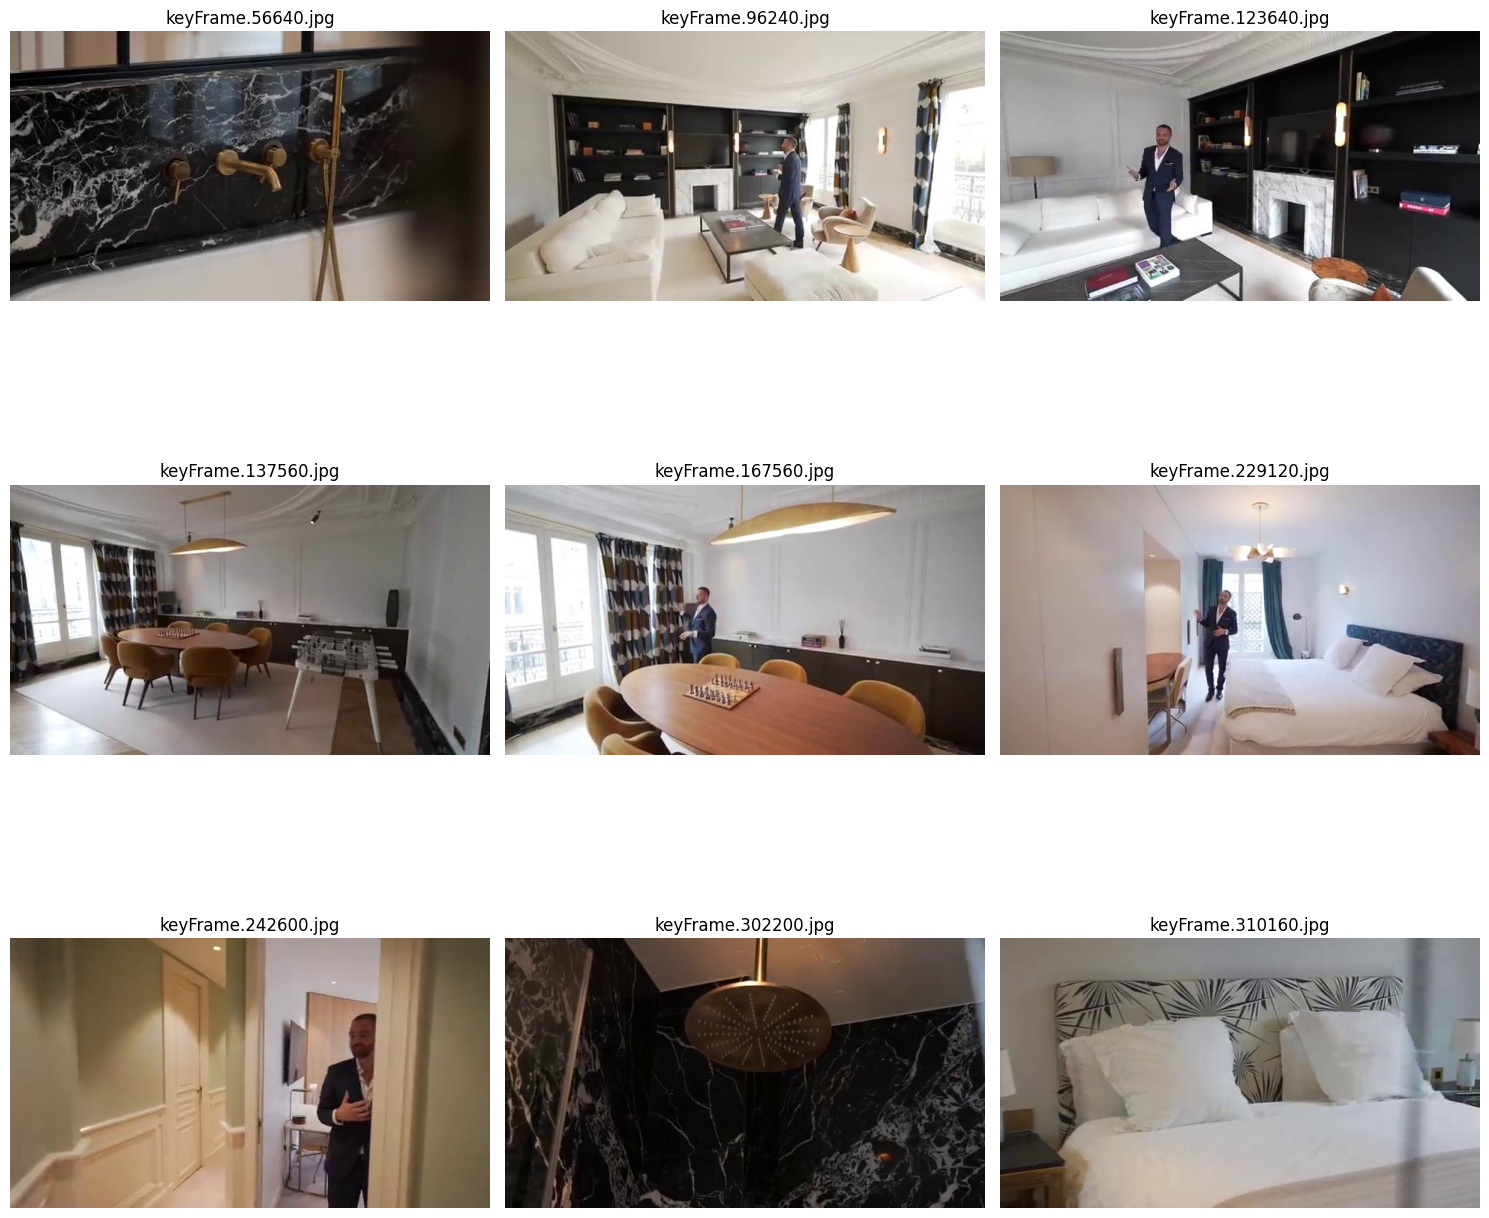

In [71]:
# List of keyframes images files
keyframe_list = get_jpg_files(IMAGES_DIR, "keyFrame")

# Get sorted list off keyframes based on the id
sorted_keyframe_list = sorted(keyframe_list, key=lambda x: int(x.split('.')[1]))

# Let's take some random images
nb_random = 9
random_images_list = [os.path.join(IMAGES_DIR, img_file) for img_file in random.sample(sorted_keyframe_list, nb_random)]
sorted_random_images_list = sorted(random_images_list, key=lambda x: int(x.split('.')[1]))

# Displaying the random images
display_images(sorted_random_images_list)

## 11. Creating the .docx document

In [77]:
from docx import Document

start = time.time()

docxfile = f"real_estate_listing_{video_file.split('/')[-1].split('.')[0]}.docx"
docx_file = os.path.join(RESULTS_DIR, docxfile)
print(f"Creating {docxfile}\n")

doc = Document()

# Header
print("Adding title...")
header = doc.sections[0].header
header_paragraph = header.paragraphs[0] if header.paragraphs else header.add_paragraph()
header_paragraph.text = "Real estate listing document"

# Writing content
print("Adding text...")
doc.add_heading("Real estate listing", level=1)
doc.add_heading("Description", level=2)
doc.add_paragraph(listing_informations)
doc.add_heading("Images", level=2)

# Saving document
doc.save(docx_file)

# Adding the images to the document with the automatic captions
print("Adding images and automatic captioning...")
for idx in range(len(random_images_list)):
    print(f"- Processing image {idx+1} of {len(random_images_list)}")
    add_image_to_docx(docx_file, random_images_list[idx], image_width=6)

elapsed = time.time() - start
print(f"\nDone in {time.strftime('%H:%M:%S' + str(elapsed % 1)[2:2], time.gmtime(elapsed))}")

Creating real_estate_listing_paris.docx

Adding title...
Adding text...
Adding images and automatic captioning...
- Processing image 1 of 9
- Processing image 2 of 9
- Processing image 3 of 9
- Processing image 4 of 9
- Processing image 5 of 9
- Processing image 6 of 9
- Processing image 7 of 9
- Processing image 8 of 9
- Processing image 9 of 9

Done in 00:01:48


In [78]:
!ls $docx_file -lh

-rwxrwxrwx 1 root root 247K Feb 25 14:08 results/real_estate_listing_paris.docx


In [79]:
DOCX_LINK = FileLink(path=docx_file)

print("Click to download the generated .docx file:")
DOCX_LINK

Click to download the generated .docx file:


/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/Real estate usecase Azure Content Understanding/results/real_estate_listing_paris.docx

## 12. Post processing (optional)

In [80]:
print(f"Removing Azure Content Understanding: {ANALYZER_ID}")
cu_client.delete_analyzer(ANALYZER_ID)
print("Done")

Removing Azure Content Understanding: realestate_25Feb2025134606
Done


In [81]:
documents, size = get_index_stats(AZURE_SEARCH_INDEX_NAME)

Azure Cognitive Search index status for: azure_cu_realestate_paris 

{
  "@odata.context": "https://azureaisearch-sr.search.windows.net/$metadata#Microsoft.Azure.Search.V2024_07_01.IndexStatistics",
  "documentCount": 108,
  "storageSize": 2366614,
  "vectorIndexSize": 671196
}


In [82]:
print(f"Deleting the Azure AI Search index: {AZURE_SEARCH_INDEX_NAME}")
search_client = SearchIndexClient(endpoint=AZURE_SEARCH_ENDPOINT, credential=AzureKeyCredential(AZURE_SEARCH_KEY))
search_client.delete_index(AZURE_SEARCH_INDEX_NAME)
print("Done")

Deleting the Azure AI Search index: azure_cu_realestate_paris
Done
